In [4]:
import keras as k
k.__version__

'2.3.1'

In [5]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to c:\users\gazur\appdata\local\temp\pip-req-build-jzcdwnps
  Resolved https://www.github.com/keras-team/keras-contrib.git to commit 3fc5ef709e061416f4bc8a92ca3750c824b5d2b0
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-py3-none-any.whl size=101654 sha256=f44c241cc8921a2f02361f574d651a0216abf4e9fd15d69b772140a370f7264e
  Stored in directory: C:\Users\gazur\AppData\Local\Temp\pip-ephem-wheel-cache-9115t0sv\wheels\bb\1f\f2\b57495012683b6b20bbae94a3915ec79753111452d79886abc
Successfully built keras-contrib


  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git 'C:\Users\gazur\AppData\Local\Temp\pip-req-build-jzcdwnps'


In [2]:
!pip install tqdm

  Using cached tqdm-4.62.2-py2.py3-none-any.whl (76 kB)


In [3]:
from __future__ import print_function, division
import scipy
from keras.models import load_model
import matplotlib.pyplot as plt
import sys
import numpy as np
import os
from tqdm import tqdm
import keras
import pandas as pd
from keras.datasets import mnist
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils import np_utils
import datetime
import matplotlib.pyplot as plt
import sys
import numpy as np
import os
import cv2

# Root directory of the project
ROOT_DIR = os.path.abspath("../")
sys.path.append(ROOT_DIR)  
import helpers

# Training file directory
DATASET = os.path.join(ROOT_DIR, 'dataset')

PATH = "{}/{}".format(DATASET, "isic2016numpy")
# load data
x_train = np.load("{}/x_train.npy".format(PATH))
y_train = np.load("{}/y_train.npy".format(PATH))
x_train.shape, y_train.shape

MODEL_PATH = os.path.join(ROOT_DIR, "models")
print(ROOT_DIR)
print(os.listdir(MODEL_PATH))

C:\Users\gazur\Desktop\Computer Vision\adversarial-lesions
['b2m.h5', 'generator_isic2016_b2m_100.h5', 'images', 'm2b.h5', 'model.h5', 'record.csv']


In [10]:
import helpers as v
v.sh

AttributeError: module 'helpers' has no attribute '__version__'

In [4]:
# Load translation model
# b2m.h5
model_name = 'generator_isic2016_b2m_100.h5'
model = load_model(os.path.join(MODEL_PATH, model_name), custom_objects={'InstanceNormalization':InstanceNormalization})
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 128, 128, 32) 1568        input_3[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_9 (LeakyReLU)       (None, 128, 128, 32) 0           conv2d_11[0][0]                  
__________________________________________________________________________________________________
instance_normalization_7 (Insta (None, 128, 128, 32) 2           leaky_re_lu_9[0][0]              
___________

C:\Anaconda\envs\GPU_Keras\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [6]:
def predict(model, img):
    
    if img.shape[0] != 256:
        print("Resizing image..")
        img = cv2.resize(img, (256, 256))
    
    # Normalize image as the trained distribution
    
    img = img/127.5 - 1.
    
    # Normalize imgae [0, 1]
    #img = img.astype('float32')
    #img /= 255.
    
    img = np.expand_dims(img, axis=0)
    img = model.predict(img)
    img = np.squeeze(img, axis=0)
    
    
    # Rescale to [0,1]
    #img = 0.5 * img + 0.5
    img = (img - np.min(img))/np.ptp(img)
    
    return img


def oversample(x, y, model):
    '''
    Some cool stuff
    INPUT
        x: 
        y:
        model:
        
    OUTPUT
        New folder in the current directory.
    '''
    
    print("Before oversampling :", x.shape, y.shape)
    
    
    # majority class
    majority_samples = []
    for img, label in zip(x, y):
        if label[1] == 0:
            majority_samples.append(img)
        else:
            pass
    
    # numpy array of majority classes
    majority_samples = np.array(majority_samples)
    
    # minority generated samples
    synthetic_samples = []
    
    # iterate over majority samples and generate minority class
    for img in tqdm(majority_samples):
        
        # translate to malignant
        pred = predict(model, img)
        synthetic_samples.append(pred)
    
    # make labels for generated minority classes
    y_syn = np.array([1 for _ in range(len(synthetic_samples))])
    y_syn = np_utils.to_categorical(y_syn, 2)
    
    # Scale training set to [0, 1]
    x = x.astype('float32')
    x /= 255
    
    # merge and shuffle training and generated samples
    x_balanced = np.concatenate( (x, synthetic_samples), axis = 0)
    y_balanced = np.concatenate( (y, y_syn), axis = 0)
    x_balanced, y_balanced = helpers.shuffle_dataset(x_balanced, y_balanced)
    
    assert len(majority_samples) == len(synthetic_samples), "This should be same! If not, check model code"
    assert len(x_balanced) == len(synthetic_samples) + len(x_train), "Check oversampler code"
    print("After oversampling: ", x_balanced.shape, y_balanced.shape)
    
    return majority_samples, synthetic_samples, x_balanced, y_balanced


In [7]:
raw, gen, x_new, y_new = oversample(x_train, y_train, model)

Before oversampling : (900, 256, 256, 3) (900, 2)


  0%|                                                                                          | 0/727 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 727/727 [01:14<00:00,  9.79it/s]


Shuffling data
After oversampling:  (1627, 256, 256, 3) (1627, 2)


### Raw data

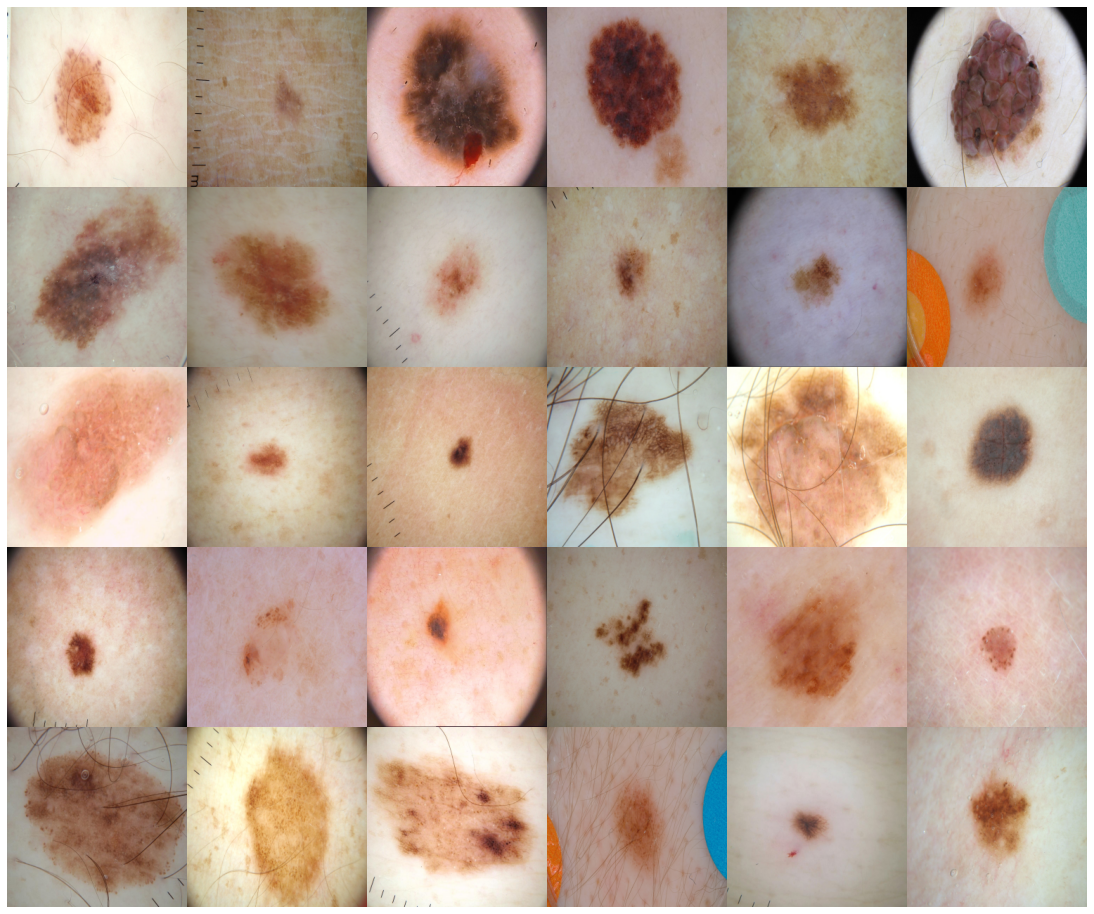

In [11]:
from numpy.random import rand
import matplotlib.pyplot as plt

index = np.random.choice(np.array(gen).shape[0], 30, replace=False)
raw = np.array(raw)
x = raw[index]

a, b = 5, 6
x = np.reshape(x, (a, b, 256, 256, 3))


test_data = x
r, c = test_data.shape[0], test_data.shape[1]
cmaps = [['viridis', 'binary'], ['plasma', 'coolwarm'], ['Greens', 'copper']]

heights = [a[0].shape[0] for a in test_data]
widths = [a.shape[1] for a in test_data[0]]

fig_width = 15.  # inches
fig_height = fig_width * sum(heights) / sum(widths)

f, axarr = plt.subplots(r,c, figsize=(fig_width, fig_height),
        gridspec_kw={'height_ratios':heights})

for i in range(r):
    for j in range(c):
        axarr[i, j].imshow(test_data[i][j])
        axarr[i, j].axis('off')
        
plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
#plt.savefig('{}/{}.png'.format("{}/outputs/".format(ROOT_DIR), "beforegan"), dpi=300)
plt.show()

### Synthesize data

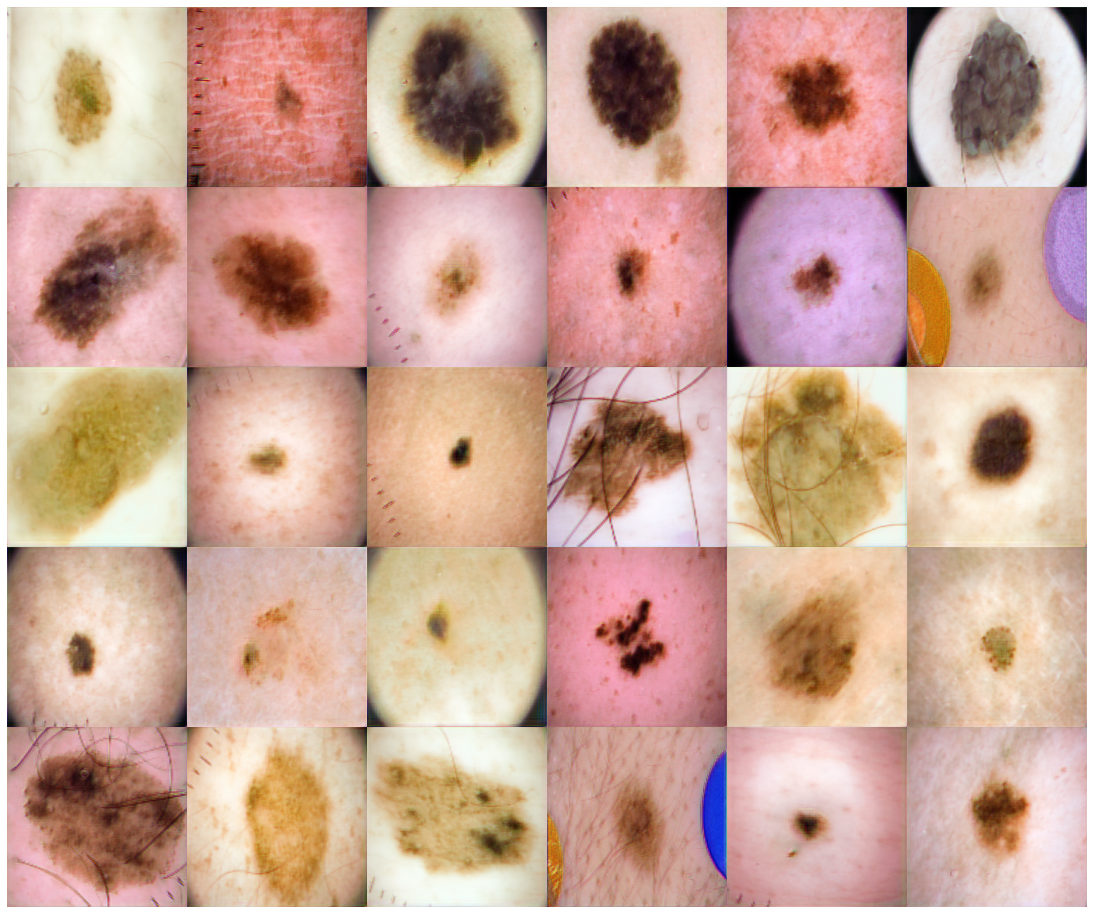

In [12]:
from numpy.random import rand
import matplotlib.pyplot as plt

gen = np.array(gen)
x = gen[index]

a, b = 5, 6
x = np.reshape(x, (a, b, 256, 256, 3))


test_data = x
r, c = test_data.shape[0], test_data.shape[1]
cmaps = [['viridis', 'binary'], ['plasma', 'coolwarm'], ['Greens', 'copper']]

heights = [a[0].shape[0] for a in test_data]
widths = [a.shape[1] for a in test_data[0]]

fig_width = 15.  # inches
fig_height = fig_width * sum(heights) / sum(widths)

f, axarr = plt.subplots(r,c, figsize=(fig_width, fig_height),
        gridspec_kw={'height_ratios':heights})

for i in range(r):
    for j in range(c):
        axarr[i, j].imshow(test_data[i][j])
        axarr[i, j].axis('off')
        
plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
#plt.savefig('{}/{}.png'.format("{}/outputs/".format(ROOT_DIR), "aftergan"), dpi=300)
plt.show()

In [13]:
x_new.shape, y_new.shape

((1627, 256, 256, 3), (1627, 2))

In [14]:
# Create directory
helpers.create_directory("{}/dataset/isic2016gan/".format(ROOT_DIR))

# Save
np.save("{}/dataset/isic2016gan/{}{}.npy".format(ROOT_DIR, "x_", "upsampled"), x_new)
np.save("{}/dataset/isic2016gan/{}{}.npy".format(ROOT_DIR, "y_", "upsampled"), y_new)

In [ ]:
print("Done!")